In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# A Model to classify cats and dogs using CNN 

In [20]:
import tensorflow as tf

In [21]:
print(tf.__version__)

2.15.0


In [22]:
# grader-required-cell

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [23]:


!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-08-12 12:54:45--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.62.142.15, 2600:1407:7400:1187::317f, 2600:1407:7400:1184::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.62.142.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: '/tmp/cats-and-dogs.zip'

/tmp/cats-and-dogs. 100%[===================>] 786.67M   217MB/s    in 3.8s    

2024-08-12 12:54:49 (205 MB/s) - '/tmp/cats-and-dogs.zip' saved [824887076/824887076]



In [24]:


source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


In [25]:

root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)


def create_train_val_dirs(root_path):
    """
    Creates directories for the train and test sets
    Args:
    root_path (string) - the base directory path to create subdirectories from
  
    Returns:
    None
    """
    os.makedirs(os.path.join(root_path, 'training', 'cats'))
    os.makedirs(os.path.join(root_path, 'training', 'dogs'))
    os.makedirs(os.path.join(root_path, 'validation','dogs'))
    os.makedirs(os.path.join(root_path, 'validation','cats'))
  
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [26]:
# grader-required-cell

# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs


In [27]:


def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    """
    Splits the data into train and test sets
  
    Args:
        SOURCE_DIR (string): directory path containing the images
        TRAINING_DIR (string): directory path to be used for training
        VALIDATION_DIR (string): directory path to be used for validation
        SPLIT_SIZE (float): proportion of the dataset to be used for training
    
  Returns:
    None
    """
    
    img_list = [img for img in os.listdir(SOURCE_DIR) if os.path.getsize(os.path.join(SOURCE_DIR,img))>0]
    random.shuffle(img_list)
    train_size = int(len(img_list)*SPLIT_SIZE)
    train = img_list[0:train_size]
    valid = img_list[train_size:]
    for img in train:
        shutil.copy(os.path.join(SOURCE_DIR,img), os.path.join(TRAINING_DIR,img))
    for img in valid:
        shutil.copy(os.path.join(SOURCE_DIR,img), os.path.join(VALIDATION_DIR,img))

In [28]:

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)


split_size = .9


split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)


print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")


print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")



Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


In [29]:
from PIL import Image
import matplotlib.pyplot as plt


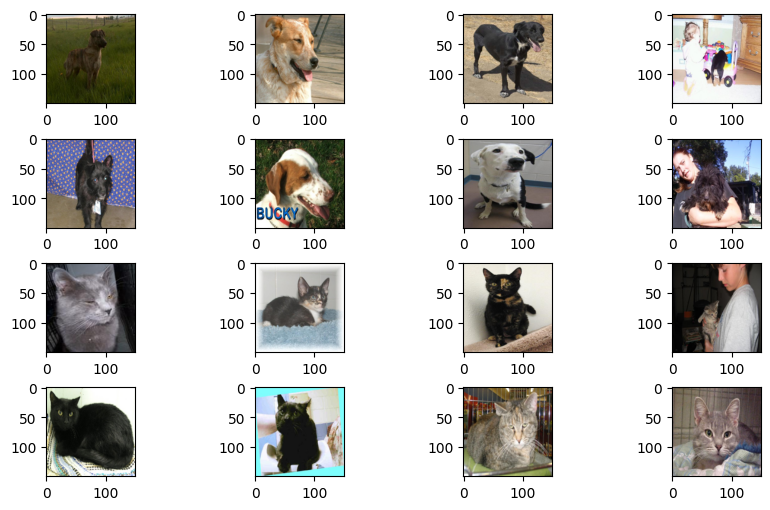

In [30]:
fig, axs = plt.subplots(4, 4, figsize=(10, 6))
dog_train = os.listdir(TRAINING_DOGS_DIR)
lookup = [TRAINING_DOGS_DIR,VALIDATION_DOGS_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR]

for i in range(4):
    file_list = os.listdir(lookup[i])
    for j in range(4):
        axs[i][j].imshow(Image.open(os.path.join(lookup[i],file_list[j])).resize((150,150)))

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [36]:

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  
  validation_datagen = ImageDataGenerator(rescale=1./255)

  
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=8,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  
  return train_generator, validation_generator

In [37]:

train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [38]:

def callback(tf.keras.)
def create_model():
  

  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Input(shape=(150, 150, 3)),
      tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid'),
  ])

  
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    

  return model

In [39]:

model = create_model()
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

None


In [40]:

history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
  1/352 ━━━━━━━━━━━━━━━━━━━━ 27:43 5s/step - accuracy: 0.5312 - loss: 0.6901

W0000 00:00:1723469630.191478     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


206/352 ━━━━━━━━━━━━━━━━━━━━ 55s 381ms/step - accuracy: 0.5446 - loss: 0.7127

W0000 00:00:1723469708.240224     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.5649 - loss: 0.6930

W0000 00:00:1723469762.174068     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


352/352 ━━━━━━━━━━━━━━━━━━━━ 141s 387ms/step - accuracy: 0.5652 - loss: 0.6928 - val_accuracy: 0.5888 - val_loss: 0.6561
Epoch 2/15


W0000 00:00:1723469766.188463     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


352/352 ━━━━━━━━━━━━━━━━━━━━ 138s 386ms/step - accuracy: 0.6601 - loss: 0.6088 - val_accuracy: 0.7236 - val_loss: 0.5327
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 139s 388ms/step - accuracy: 0.7036 - loss: 0.5609 - val_accuracy: 0.7404 - val_loss: 0.5191
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 140s 391ms/step - accuracy: 0.7257 - loss: 0.5400 - val_accuracy: 0.7312 - val_loss: 0.5292
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 139s 388ms/step - accuracy: 0.7384 - loss: 0.5191 - val_accuracy: 0.7820 - val_loss: 0.4596
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 140s 390ms/step - accuracy: 0.7596 - loss: 0.4952 - val_accuracy: 0.8008 - val_loss: 0.4114
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 139s 388ms/step - accuracy: 0.7697 - loss: 0.4772 - val_accuracy: 0.8244 - val_loss: 0.4001
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 140s 391ms/step - accuracy: 0.7753 - loss: 0.4672 - val_accuracy: 0.8232 - val_loss: 0.3886
Epoch 9/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 140s 391ms/step - accuracy: 0.7932 - loss: 0.44